# Waveform Analysis Exploration 

Need a function for mass data addition (all the unique EDF files). I'll merge them into a single table for easy analysis. Waves are waves-- so long as they have the same filtering and they're all originally raw EEG! 

Since there's a major problem with unreliable annotations, I'm taking matters into my own hands and manually constructing a label list for fixed 30s intervals. I'll do this by binning annotations from the paired Hypnogram for each file. 
- Going to time-align the labels using `raw.annotations` 
- Then slice the entire sleep period into 30s chunks 
- Finally, assign the sleep stage based on the label-list 

In [22]:
import numpy as np
import pandas as pd
import mne 
from mne.time_frequency import psd_array_welch
import matplotlib.pyplot as plt
import os

def process_edf_pair(psg_path, hypnogram_path): 
    '''
    Loads EDF EEG recording and corresponding hypnogram 
    Extracts 30s epochs, labels them, and returns a features df

    Returns: 
        features (pd.DataFrame): Features + newly created 'label' col (sleep stage as str)
    '''

    raw = mne.io.read_raw_edf(psg_path, preload=True) 
    raw.set_annotations(mne.read_annotations(hypnogram_path))
    raw.pick(['EEG Fpz-Cz']) 

    data = raw.get_data()[0]
    sfreq = raw.info['sfreq']
    total_duration = int(data.shape[-1] / sfreq) # in seconds!

    # Map annotation label -> clean stage name
    stage_map = {
        'Sleep stage W': 'Wake',
        'Sleep stage 1': 'N1',
        'Sleep stage 2': 'N2',
        'Sleep stage 3': 'N3',
        'Sleep stage 4': 'N3', # Mergnig 4 into N3
        'Sleep stage R': 'REM'
    }

    epoch_length = 30 # seconds
    n_epochs = total_duration // epoch_length
    labels = ['UNKNOWN'] * n_epochs

    for ann in raw.annotations:
        label = stage_map.get(ann['description'], None)
        if label is None: 
            continue
        start = int(ann['onset']) // epoch_length
        duration = int(ann['duration']) // epoch_length

        for i in range(start, min(start + duration, n_epochs)):
            labels[i] = label

    # Remove unknown-labeled epochs
    valid_idxs = [i for i, l in enumerate(labels) if l != 'UNKNOWN'] 

    # Manually epoch the signal into 30s chunks 
    samples_per_epoch = int(epoch_length * sfreq) 
    epoch_data = np.array([
        data[i * samples_per_epoch:(i+1) * samples_per_epoch]
        for i in valid_idxs if (i+1) * samples_per_epoch <= len(data) 
    ])
        
    # Compute bandpower features 
    psds, freqs = psd_array_welch(epoch_data[:, np.newaxis, :], sfreq=sfreq, fmin=0.5, fmax=40, n_fft=256)

    features = pd.DataFrame({
        'delta': bandpower(psds, freqs, (0.5, 4)),
        'theta': bandpower(psds, freqs, (4, 8)),
        'alpha': bandpower(psds, freqs, (8, 13)),
        'beta':  bandpower(psds, freqs, (13, 30)),
        'label': [labels[i] for i in valid_idxs]
    })

    # Adding subject ID derived from filename (ex. "ST7011J") 
    subj_id = os.path.basename(psg_path)[2:6]
    features['subject_id'] = subj_id

    return features

def bandpower(psds, freqs, band):
    '''
    Small hepler for process_edf_pair
    Returns mean band power in specified frequency band
    '''
    idx = (freqs >= band[0]) & (freqs <= band[1])
    return psds[:, :, idx].mean(axis=-1).mean(axis=1)



### Now Loop over all .edf files!

In [ ]:
import os

# Match PSG and Hypnogram files by prefix
data_dir = '../data/sleep_waves/'
files = os.listdir(data_dir) 

# Grouping PSG and Hypnogram files by shared sybject root (first 7 chars) 
psg_files = [f for f in files if f.endswith('-PSG.edf')]
hyp_files = [f for f in files if 'Hypnogram' in f] 

file_pairs = []

for psg in psg_files:
    subj_root = psg[:7] # example: 'ST7011J'
    matching_hyp = [h for h in hyp_files if h.startswith(subj_root)]

    if matching_hyp: 
        psg_path = os.path.join(data_dir, psg) 
        hyp_path = os.path.join(data_dir, matching_hyp[0]) # Note: assuming only 1 match! 
        file_pairs.append((psg_path, hyp_path)) 
    else: 
        print(f'No matching hypnogram for {psg}')

print(f'Found {len(file_pairs)} valid PSG-Hypnogram edf pairs') 

# Process all and concat 
all_feats = []

for psg, hyp in file_pairs:
    print(f"🧪 Processing: {os.path.basename(psg)} & {os.path.basename(hyp)}")
    try: 
        features = process_edf_pair(psg, hyp)
        all_feats.append(features) 
        print(f'\n✅ Processed: {os.path.basename(psg)}:{len(features)} epochs\n')
    except Exception as e: 
        print(f'❌ Failed on {psg}: {e}')

df_edf = pd.concat(all_feats, ignore_index=True) 




### Why Distinguish Between Subjects? 
Sleep progresses through ~4-5 distinct cycles per night (each 90-100 mins). Each cycle starts in N1 / Wake (still digging for this answer), and progresses to REM. We've learned that later cycles (in a typical night sleep) have less N3 and more REM.  
  
  Since these patterns are subject-specific, it makes sense to segmenet by subject and learn from these cycles within a given night. If we know where cycles start and end, the HMM can follow real transitions, preventing overfitting.

### Adding new column `cycle` before model training:

#### Cycle Conditions 
- Wake --> N1 or N2 (start of sleep)
- REM --> Wake (likely end of cycle)
- Duration > 220 epochs (110 mins) 

Assigning a `cycle` column. Resets to 0 for each subject, allowing for easier cycle tracking.

In [ ]:
def segment_subject_cycles(df: pd.DataFrame, min_cycle_len=60, max_cycle_len=140, min_rem_epochs=4): 
    '''
    Segments sleep data into cycles per subject, based on sleep stage transitions
    Assumes 30s epochs. Each cycle is marked after a qualifying REM streak

    Args: 
        df: EEG data-- requires 'label' and 'subject_id' col 
        min_cycle_len (int): min expected cycle length (60 mins)
        max_cycle_len (int): max expected cycle length (120 mins)
        min_rem_epochs (int): min number of REM epochs to consider a valid REM phase

    Returns: 
        df: original df with added 'cycle' column, segmented per subject
    '''

    df = df.copy()
    all_segmented = []

    # Epoch = 30s 
    min_len = (min_cycle_len * 2) 
    max_len = (max_cycle_len * 2) 

    for subject_id, subject_df in df.groupby('subject_id'): 
        labels = subject_df['label'].values
        cycle_col = np.zeros(len(labels), dtype=int) 

        cycle = 0 
        last_idx = 0 
        rem_streak = 0
        rem_end_idx = None

        for i in range(1, len(labels)): 
            cycle_col[i] = cycle

            if labels[i] == 'REM': 
                rem_streak += 1
                rem_end_idx = i # Update while REM continues!
            else: 
                if rem_streak >= min_rem_epochs and rem_end_idx is not None:
                    span = np.sum(~np.isin(labels[last_idx:rem_end_idx + 1], ['Wake', 'UNKNOWN']))
                    if min_len <= span <= max_len: 
                        cycle += 1 
                        last_idx = rem_end_idx + 1 # Start next cycle after REM block!
                rem_streak = 0 
                rem_end_idx = None

        subject_df = subject_df.copy()
        subject_df['cycle'] = cycle_col 
        all_segmented.append(subject_df) 

    return pd.concat(all_segmented, ignore_index=True) 

In [25]:
df_edf = segment_subject_cycles(df_edf)
df_edf

,delta,theta,alpha,beta,label,subject_id,cycle
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake,7011,0
1,4.988774e-10,1.235113e-11,4.446865e-12,2.844799e-12,Wake,7011,0
2,1.534984e-10,2.390680e-12,1.519197e-12,5.406593e-13,Wake,7011,0
3,4.962507e-11,2.943184e-12,1.687577e-12,5.375286e-13,Wake,7011,0
4,2.378089e-11,1.779550e-12,2.156748e-12,4.648331e-13,Wake,7011,0
...,...,...,...,...,...,...,...
42686,4.120337e-11,7.154511e-12,1.723270e-12,2.457063e-13,N2,7242,4
42687,9.937038e-11,4.455668e-12,1.793157e-12,3.096157e-13,N2,7242,4
42688,2.846232e-10,1.342760e-11,3.760796e-12,3.510913e-12,Wake,7242,4
42689,9.707442e-10,2.485227e-11,6.117589e-12,8.264715e-12,Wake,7242,4


In [26]:
df_edf.to_csv('../data/eeg_hypno.csv', index=False)

df_edf

,delta,theta,alpha,beta,label,subject_id,cycle
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake,7011,0
1,4.988774e-10,1.235113e-11,4.446865e-12,2.844799e-12,Wake,7011,0
2,1.534984e-10,2.390680e-12,1.519197e-12,5.406593e-13,Wake,7011,0
3,4.962507e-11,2.943184e-12,1.687577e-12,5.375286e-13,Wake,7011,0
4,2.378089e-11,1.779550e-12,2.156748e-12,4.648331e-13,Wake,7011,0
...,...,...,...,...,...,...,...
42686,4.120337e-11,7.154511e-12,1.723270e-12,2.457063e-13,N2,7242,4
42687,9.937038e-11,4.455668e-12,1.793157e-12,3.096157e-13,N2,7242,4
42688,2.846232e-10,1.342760e-11,3.760796e-12,3.510913e-12,Wake,7242,4
42689,9.707442e-10,2.485227e-11,6.117589e-12,8.264715e-12,Wake,7242,4


In [21]:
import pandas as pd

# Load the updated CSV file
df = pd.read_csv('../data/eeg_hypno.csv')

# Filter for subject 7011
subject_7011 = df[df['subject_id'] == 7011].reset_index(drop=True)

# Check the value counts of cycle column to get cycle distribution
cycle_distribution = subject_7011['cycle'].value_counts().sort_index()

# Check where cycle transitions occur
subject_7011['cycle_change'] = subject_7011['cycle'].diff().fillna(0).ne(0)

# Focus on the problematic section from cycle 3 onward
after_cycle_3 = subject_7011[subject_7011['cycle'] >= 3]

# Count REMs within the problematic area
rem_streaks = after_cycle_3['label'].eq('REM').astype(int)

# Check longest REM streak within the cycle >= 3 zone
rem_streak_lengths = rem_streaks.groupby(rem_streaks.ne(rem_streaks.shift()).cumsum()).sum()

after_cycle_3_start_index = subject_7011[subject_7011['cycle'] == 3].index[0]

(after_cycle_3.head(20), cycle_distribution, rem_streak_lengths.sort_values(ascending=False).head(10), after_cycle_3_start_index)


(            delta         theta         alpha          beta label  subject_id  \
 436  6.000278e-12  4.165632e-12  1.518577e-12  5.389868e-13    N1        7011   
 437  4.100465e-11  1.412482e-11  2.410052e-12  6.361563e-13    N2        7011   
 438  4.552100e-11  9.505402e-12  1.668170e-12  6.958425e-13    N2        7011   
 439  4.580635e-11  6.770875e-12  2.308565e-12  4.922427e-13    N2        7011   
 440  2.434543e-11  8.388278e-12  2.216716e-12  1.233108e-12    N2        7011   
 441  1.458869e-10  5.686859e-12  2.762954e-12  2.125304e-12  Wake        7011   
 442  1.236373e-09  4.155885e-11  6.151850e-12  4.496759e-12  Wake        7011   
 443  4.436090e-10  3.212341e-11  2.944308e-12  8.002102e-13  Wake        7011   
 444  7.205938e-10  1.410224e-11  1.812339e-12  1.367909e-12  Wake        7011   
 445  5.507296e-10  7.683485e-12  2.604376e-12  6.220623e-13  Wake        7011   
 446  2.907716e-10  1.667144e-11  3.947145e-12  1.027118e-12  Wake        7011   
 447  2.319915e-

<hr>

# Quickload through the .csv
Skip to here to avoid generating files for the thousanth time

In [1]:
import sys 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_edf = pd.read_csv('../data/eeg_hypno.csv')
df_edf

,delta,theta,alpha,beta,label,subject_id,cycle
0,6.160000e-12,3.310000e-12,1.940000e-12,2.370000e-12,Wake,7011,0
1,4.990000e-10,1.240000e-11,4.450000e-12,2.840000e-12,Wake,7011,0
2,1.530000e-10,2.390000e-12,1.520000e-12,5.410000e-13,Wake,7011,0
3,4.960000e-11,2.940000e-12,1.690000e-12,5.380000e-13,Wake,7011,0
4,2.380000e-11,1.780000e-12,2.160000e-12,4.650000e-13,Wake,7011,0
...,...,...,...,...,...,...,...
42686,4.120000e-11,7.150000e-12,1.720000e-12,2.460000e-13,N2,7242,4
42687,9.940000e-11,4.460000e-12,1.790000e-12,3.100000e-13,N2,7242,4
42688,2.850000e-10,1.340000e-11,3.760000e-12,3.510000e-12,Wake,7242,4
42689,9.710000e-10,2.490000e-11,6.120000e-12,8.260000e-12,Wake,7242,4


### Training a Basic Classifier (RF)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

X = df_edf.drop(columns=['label'])
y = df_edf['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)

base_rf = RandomForestClassifier(n_estimators=100, random_state=10, class_weight='balanced')
base_rf.fit(X_train, y_train) 

y_pred = base_rf.predict(X_test) 
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          N1       0.56      0.31      0.40       731
          N2       0.78      0.90      0.84      3970
          N3       0.85      0.82      0.83      1283
         REM       0.79      0.73      0.76      1670
        Wake       0.78      0.68      0.73       885

    accuracy                           0.78      8539
   macro avg       0.75      0.69      0.71      8539
weighted avg       0.77      0.78      0.77      8539



### Pipeline Project Adapted to Waveforms (LONG WAIT, HYPERPARAM TUNING):

In [3]:
import sys
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

import sys 
import os
sys.path.append(os.path.abspath(".."))

from src.run_pipeline import tune_and_train_full

# Label Encoding with decoding built into tune_and_train_full()
le = LabelEncoder()
y_encoded = le.fit_transform(y) 

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, stratify=y_encoded, random_state=10)

lgbm_wave, best_params = tune_and_train_full(
    model_class=LGBMClassifier,
    model_name='LGBM_wave',
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_params={'class_weight': 'balanced'},
    sample_frac=0.9,
    scoring='f1_weighted',
    use_scaler=False,
    n_trials=50,
    label_encoder=le  
)

🔍 Sampled 28816 rows (90.0%)
Class distribution:
1    13399
3     5636
2     4330
4     2985
0     2466



🔍 Tuning: 100%|████████████████████████████████████████████████████| 50/50 [09:12<00:00, 11.05s/it]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 28816, number of used features: 6
[LightGBM] [Info] Start training from score -2.458333
[LightGBM] [Info] Start training from score -0.765751
[LightGBM] [Info] Start training from score -1.895363
[LightGBM] [Info] Start training from score -1.631756
[LightGBM] [Info] Start training from score -2.267331
[TRAINING] Starting model training...

→ Training LGBM_wave with params:
{
    "class_weight": "balanced",
    "n_estimators": 200,
    "max_depth": 32,
    "learning_rate": 0.05209032565537784,
    "num_leaves": 122
}
Scaling: OFF
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [In

In [3]:
sys.path.append(os.path.abspath(".."))

import joblib
from sklearn.preprocessing import LabelEncoder
from src.eval import eval_classification 

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y is label column
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=10)

lgbm_pipeline = joblib.load('../models/LGBM_wave.pkl')

eval_classification(lgbm_pipeline, X_test, y_test, label_encoder=le) 



Label decoder active:
  y_test unique: [0 1 2 3 4]
  Classes: ['N1' 'N2' 'N3' 'REM' 'Wake']

Evaluating Model: LGBMClassifier
Hyperparameters:
{
    "boosting_type": "gbdt",
    "class_weight": "balanced",
    "colsample_bytree": 1.0,
    "importance_type": "split",
    "learning_rate": 0.05209032565537784,
    "max_depth": 32,
    "min_child_samples": 20,
    "min_child_weight": 0.001,
    "min_split_gain": 0.0,
    "n_estimators": 200,
    "n_jobs": null,
    "num_leaves": 122,
    "objective": null,
    "random_state": null,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0,
    "subsample": 1.0,
    "subsample_for_bin": 200000,
    "subsample_freq": 0
}

Overall Metrics:
| Metric             |   Score |
|:-------------------|--------:|
| Accuracy           |  0.7953 |
| Weighted Precision |  0.8021 |
| Weighted Recall    |  0.7953 |
| Weighted F1-Score  |  0.7976 |

Class-Specific Metrics:
| Class   |   Precision |   Recall |   F1-Score |   Support |
|:--------|------------:|---------:|

## Great, Classifier is Built! What Now?
Just completed work on a sleep stage classifier that is ~80% effective. While that's not bad... we can do better, by using the elements of the data to our advantage: 
- Sleep is **not** random, it follows structured stage transitions
- HMM can capture those structured transitions as probabilities
- We can use a HMM approach to smooth the pipeline model's predictions into a more biologically probably sequence.


### While Discussing Goals: 
**Real-time sleep classification**. It's possible (with a ton of work). That is our final product. 

<hr>

### Back to Reality: HMM Smoothing Pass 

It's important to remember that the HMM is *not* making new predictions or replacing the already nicely trained and optimized classifier. The HMM will function to refine the outputs.  
  
We'll learn from the data in order to estimate stage transition probabilities. For example: how likely are you to stay in N2, or jump to N3, etc. 

In [58]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np

def apply_hybrid_hmm(df: pd.DataFrame, base_predictions, label_encoder, transition_matrices): 
    '''
    Applies hybrid GaussianHMM smoothing to predicted labels using per-cycle transition matrices

    Args: 
        df (pd.DataFrame): EEG data with 'cycle' and 'subject_id' cols
        base_predictions (np.ndarray): Raw model predictions (same order as df) 
        label_encoder (LabelEncoder): Fitted encoder to convert betweeen stages labels and indices
        transition_matrices (dict): 
            Keys= 'early', 'mid', 'late'
            Values= 2D np.ndarray (5x5 transitions)

    Returns: 
        np.ndarray: smoothed predictions using cycle-aware HMM pass-over 
    '''

    df = df.copy()
    df['pred'] = base_predictions

    stage_order = label_encoder.classes_
    n_states = len(stage_order) 

    smoothed_all = []
    used_indices = [] 

    for (subject_id, cycle), group in df.groupby(['subject_id', 'cycle']): 
        if len(group) < n_states:
            print(f"⏭️ Skipping subject {subject_id}, cycle {cycle} — only {len(group)} rows")
            continue

        X = group[['delta', 'theta', 'alpha', 'beta']].values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X) 

        hmm_model = GaussianHMM(n_components=n_states, 
                        covariance_type='full', 
                        n_iter=100, 
                        random_state=10)
        
        # startprob = np.full(n_states, 0.01)
        # wake_index = label_encoder.transform(['Wake'])[0]
        # startprob[wake_index] = 0.95
        # hmm_model.startprob_ = startprob / startprob.sum()
        
        hmm_model.fit(X_scaled) 

        row_sums = hmm_model.transmat_.sum(axis=1)
        if not np.allclose(row_sums, 1):
            print(f"⚠️ Fixing transmat_ for subject {subject_id}, cycle {cycle}")
            transmat = hmm_model.transmat_
            transmat[row_sums == 0] = np.full(n_states, 1.0 / n_states)
            transmat /= transmat.sum(axis=1, keepdims=True)
            hmm_model.transmat_ = transmat

        # # Select transition matrix based on cycle phase
        # if cycle <= 1: 
        #     phase = 'early'
        # elif cycle <= 3:
        #     phase = 'mid'
        # else: 
        #     phase = 'late'

        # transmat = transition_matrices[phase]

        
        # hmm_model.transmat_ = transmat
        
        # Step 3: Override learned transition with hybrid transition logic 
        # hmm_model.transmat_ = transmat.copy()


        # Step 4: Predict (Viterbi) and Decode!
        smoothed_idx = hmm_model.predict(X_scaled)
        smoothed_labels = label_encoder.inverse_transform(smoothed_idx) 

        smoothed_all.extend(smoothed_labels) 
        used_indices.extend(group.index.tolist())

    return np.array(smoothed_all), np.array(used_indices)
    

In [59]:

# Order: ['N1', 'N2', 'N3', 'REM', 'Wake']
transition_matrices = {
    "early": np.array([
        [0.10, 0.85, 0.00, 0.00, 0.05],  # N1 → mostly N2
        [0.00, 0.80, 0.15, 0.00, 0.05],  # N2 → N3
        [0.00, 0.30, 0.65, 0.00, 0.05],  # N3 → N2
        [0.00, 0.00, 0.00, 0.90, 0.10],  # REM → Wake
        [0.40, 0.50, 0.00, 0.00, 0.10],  # Wake → N1/N2
    ]),

    "mid": np.array([
        [0.10, 0.85, 0.00, 0.00, 0.05],
        [0.05, 0.75, 0.10, 0.05, 0.05],
        [0.05, 0.30, 0.60, 0.00, 0.05],
        [0.00, 0.10, 0.00, 0.80, 0.10],
        [0.30, 0.60, 0.00, 0.00, 0.10],
    ]),

    "late": np.array([
        [0.10, 0.80, 0.00, 0.05, 0.05],
        [0.10, 0.65, 0.00, 0.15, 0.10],
        [0.10, 0.20, 0.50, 0.00, 0.20],
        [0.05, 0.15, 0.00, 0.75, 0.05],
        [0.20, 0.65, 0.00, 0.10, 0.05],
    ])
}

In [60]:
# base_predictions = le.inverse_transform(rf_pipeline.predict(X))
base_preds = rf_pipeline.predict(X) 

smoothed_preds, used_indices = apply_hybrid_hmm(df_edf, base_preds, le, transition_matrices)

⚠️ Fixing transmat_ for subject 7012, cycle 3
⚠️ Fixing transmat_ for subject 7061, cycle 5
⚠️ Fixing transmat_ for subject 7091, cycle 4
⚠️ Fixing transmat_ for subject 7102, cycle 1
⚠️ Fixing transmat_ for subject 7141, cycle 3
⚠️ Fixing transmat_ for subject 7152, cycle 4
⚠️ Fixing transmat_ for subject 7171, cycle 3
⚠️ Fixing transmat_ for subject 7192, cycle 3
⏭️ Skipping subject 7192, cycle 5 — only 2 rows
⚠️ Fixing transmat_ for subject 7242, cycle 3
⚠️ Fixing transmat_ for subject 7242, cycle 4


### Ready to Visualize the Hybrid HMM's performance

Classification Report
              precision    recall  f1-score   support

          N1      0.099     0.305     0.149      3653
          N2      0.503     0.191     0.277     19851
          N3      0.197     0.228     0.211      6415
         REM      0.258     0.298     0.276      8349
        Wake      0.116     0.180     0.141      4421

    accuracy                          0.226     42689
   macro avg      0.235     0.240     0.211     42689
weighted avg      0.335     0.226     0.242     42689



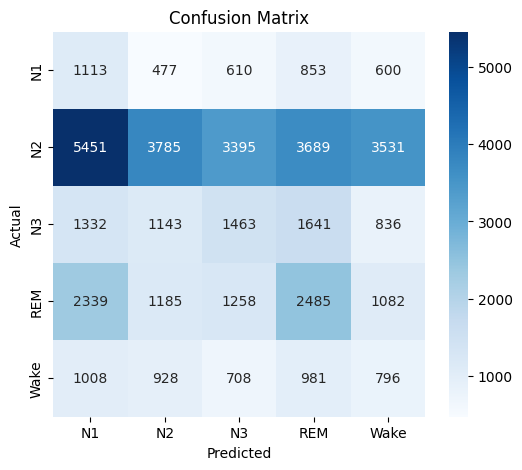

In [61]:
from src.eval import eval_predictions

eval_predictions(smoothed_preds, np.array(y)[used_indices], le)


Classification Report
              precision    recall  f1-score   support

          N1      0.481     0.499     0.490       913
          N2      0.855     0.836     0.845      4963
          N3      0.825     0.880     0.852      1604
         REM      0.792     0.789     0.790      2087
        Wake      0.787     0.773     0.780      1106

    accuracy                          0.798     10673
   macro avg      0.748     0.755     0.751     10673
weighted avg      0.799     0.798     0.798     10673



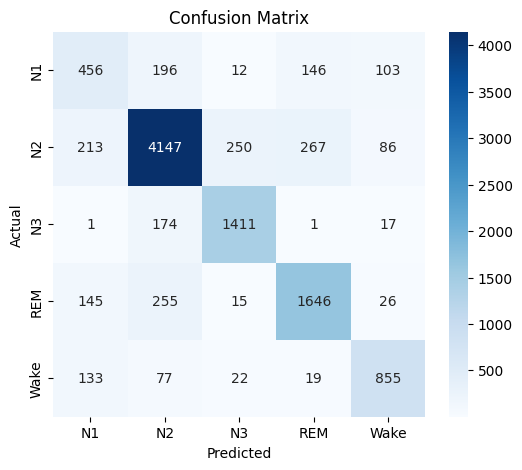

In [4]:
from src.eval import eval_predictions

eval_predictions(light_wave.predict(X_test), y_test, le)

In [4]:
from tkinter import font
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def plot_subject_sequence(subject_id, model, model_name, df: pd.DataFrame, label_encoder, label_order=None, n_epochs=50):
    '''
    Visualizes sleep stage preds vs ground truth for a specific subject

    Args: 
        subject_id (int): subject ID to filter rows
        model: Trained classifier with .predict() 
        model_name (str): Name of the model for the plot title
        df (pd.DataFrame): full dataset with 'label' and 'subject_id'
        label_encoder: Fitted label encoder (decoding preds)
        label_order (list): Optional fixed order of labels 
        n_epochs (int): Number of epochs to plot (default=50)
    '''
    # Filter for the subject: 
    df_subj = df[df['subject_id'] == subject_id].copy()

    # Predict: 
    X_subj = df_subj.drop(columns=['label'])
    y_true = df_subj['label'].values

    y_pred = label_encoder.inverse_transform(model.predict(X_subj))

    # For safety, clip to n_epochs available
    n_epochs = min(n_epochs, len(df_subj))
    y_true, y_pred = y_true[:n_epochs], y_pred[:n_epochs] 
    df_subj = df_subj.iloc[:n_epochs]
    
    # Label Mapping
    if label_order is None: 
        label_order = sorted(list(set(y_true) | set(y_pred)))

    label_to_int = {label: i for i, label in enumerate(label_order)} 
    y_true_idx = [label_to_int[y] for y in y_true]
    y_pred_idx = [label_to_int[y] for y in y_pred]

    # Add a thin white row separator between Ground Truth and Classifier
    data = np.array([y_true_idx, y_pred_idx])

    stage_colors = {
        "Wake": "#9b59b6",  # Soft lavender
        "N1": "#f1c40f",     # Yellow
        "REM": "#e67e22",    # Rich orange (darker than N1)
        "N2": "#1abc9c",     # Teal
        "N3": "#2c3e50"      # Dark blue-gray
    }

    cmap = ListedColormap([stage_colors[stage] for stage in label_order])

    fig, ax = plt.subplots(figsize=(16, 3))
    ax.imshow(data, 
              cmap=cmap, 
              aspect='auto', 
              interpolation='none', 
              extent=[0, data.shape[1], 0, data.shape[0]])

    # Cycle markers with annotations
    if 'cycle' in df_subj.columns:
        cycle_seq = df_subj['cycle'].values[:n_epochs]
        for i in range(1, len(cycle_seq)):
            if cycle_seq[i] != cycle_seq[i - 1]:
                ax.axvline(i - 0.5, color='black', linestyle='--', linewidth=3)
                ax.text(i, 1.08, f"Cycle {cycle_seq[i]}", rotation=0,
                        verticalalignment='top', horizontalalignment='center', 
                        fontsize=14, fontweight='bold')

    # X-axis ticks every 200 epochs
    ax.set_xticks(np.arange(0, n_epochs + 1, 200)) 

    # Draw white horizontal separator line
    ax.axhline(y=1, color='white', linewidth=9)

    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels([f'{model_name}', 'Ground Truth'], fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.set_title(f"Sleep Stage Sequence – Subject {subject_id}", fontsize=26)

    handles = [plt.Line2D([0], [0], color=stage_colors[stage], lw=6) for stage in label_order]
    ax.legend(handles, label_order, bbox_to_anchor=(1.01, 1), loc='upper left', title="Stages", fontsize=12, title_fontsize=13)

    plt.tight_layout()
    plt.show()


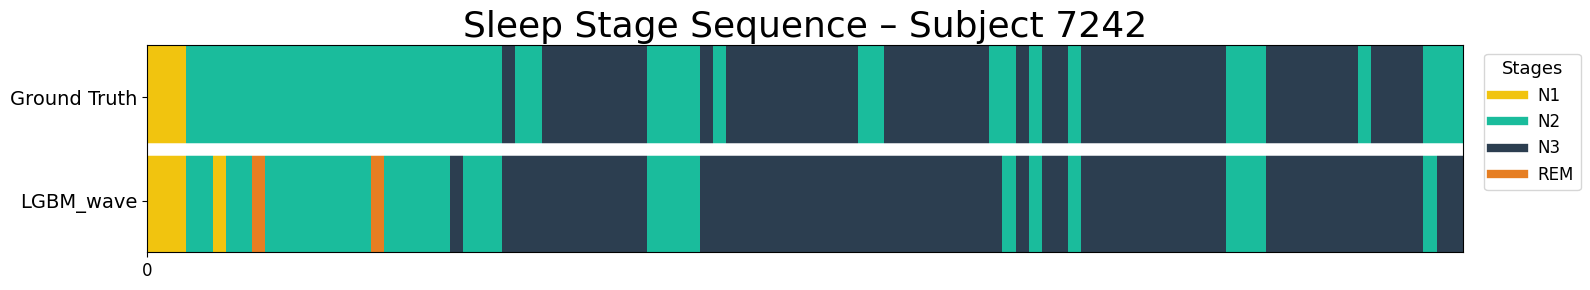

In [7]:
plot_subject_sequence(
    subject_id = 7242, 
    model=lgbm_pipeline,
    model_name='LGBM_wave',
    df=df_edf,
    label_encoder=le, 
    n_epochs=100
)

## Plots Look Awesome... Maybe *Too* Awesome? 
I'm quite concerned about the model being **overfit**, so let's test that by performing some cross-validation. Specifically unique to this data, I'll adapt Leave-One-Out-CV (LOO-CV) for Leave-One-Subject-Out-CV (LOSO-CV). It'll involve holding a random subject_id out of the model training process. That way we can simulate testing our model's performance on completely new data!

In [15]:
def leave_one_subject_out(df: pd.DataFrame, model_class, model_name: str, n_trials=30):
    '''
    Performs leave-one-subject-out cross-validation

    Args:
        df (pd.DataFrame): Dataset including 'label' and 'subject_id'
        model_class: Classifier to train (e.g., LGBMClassifier)
        model_name (str): Name used for reporting
        n_trials (int): Number of Optuna trials for tuning

    Returns:
        results (dict): Dictionary mapping subject_id to evaluation result
    '''

    results = {}
    subjects = df['subject_id'].unique()

    for left_out in subjects:
        print(f"\n🚪 Leaving out Subject {left_out}...")

        df_train = df[df['subject_id'] != left_out].copy()
        df_test = df[df['subject_id'] == left_out].copy()

        if df_test.empty:
            print(f"⚠️ No data found for subject {left_out}, skipping.")
            continue

        le = LabelEncoder()
        le.fit(df_train['label']) 

        y_train = le.fit_transform(df_train['label'])
        y_test_decoded = df_test['label'].values

        X_train = df_train.drop(columns=['label'])
        X_test = df_test.drop(columns=['label']) 

        trained_model, best_params = tune_and_train_full(
        model_class=model_class,
        model_name=f"{model_name}_{left_out}",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test_decoded, # not encoded!
        model_params={'class_weight': 'balanced'},
        sample_frac=0.9,
        scoring='f1_weighted',
        use_scaler=False,
        n_trials=n_trials,
        label_encoder=le
    )
        
    results[left_out] = {
        'model' : trained_model,
        'best_params' : best_params, 
        'label_encoder' : le,
    }

    return results

    

In [16]:
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from src.run_pipeline import tune_and_train_full

loso_results = leave_one_subject_out(
    df = df_edf, 
    model_class=LGBMClassifier,
    model_name='LGBM_loso') 



🚪 Leaving out Subject 7011...
🔍 Sampled 37439 rows (90.0%)
Class distribution:
1    17390
3     7404
2     5651
4     3797
0     3197



🔍 Tuning:   0%|                                                             | 0/30 [00:00<?, ?it/s]

🔍 Tuning: 100%|████████████████████████████████████████████████████| 30/30 [07:07<00:00, 14.26s/it]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1070
[LightGBM] [Info] Number of data points in the train set: 37439, number of used features: 6
[LightGBM] [Info] Start training from score -2.460500
[LightGBM] [Info] Start training from score -0.766818
[LightGBM] [Info] Start training from score -1.890880
[LightGBM] [Info] Start training from score -1.620693
[LightGBM] [Info] Start training from score -2.288502
[TRAINING] Starting model training...

→ Training LGBM_loso_7011 with params:
{
    "class_weight": "balanced",
    "n_estimators": 300,
    "max_depth": 43,
    "learning_rate": 0.03219273636127056,
    "num_leaves": 83
}
Scaling: OFF
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

ValueError: Mix of label input types (string and number)